In [8]:
# Imports + unified config
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio, display

from py_scripts.additive_synth_opt import (
    AdditiveObjective, additive_synth,
    run_de_optimization, run_dual_annealing, run_basinhopping,
    save_and_display_final_values_additive, make_fft, plot_time, plot_spectrum
)
from py_scripts.fm_synth_opt import synthesize_target_additive, save_wav
from py_scripts.waveform_generators import sine_wave, square_wave, triangle_wave, sawtooth_wave, noise_wave

# --- deterministic config ---
SR = 44100
DURATION = 1.0
FFT_PAD = 2
FADE_IN_MS = 10.0
FADE_OUT_MS = 10.0

# Metrics: 'itakura_saito', 'spectral_convergence', 'cosine', 'euclidean', 'manhattan', 'kl', 'pearson', 'mfcc'
METRIC = 'cosine'

# Optimizer method: 'de' (differential evolution), 'da' (dual annealing), 'bh' (basinhopping)
METHOD = 'de'

# Number of oscillators (partials)
N_PARTIALS = 4

# Enable per-oscillator waveform selection (triplet params: f, a, waveform_idx)
USE_WAVEFORMS = True
waveforms = [sine_wave, square_wave, triangle_wave, sawtooth_wave, noise_wave]

# Target TSV (adjust as needed)
target_path = 'tsv/voice-single2.tsv'
assert isinstance(target_path, str)


In [9]:
# Load target partials + preview
if not os.path.exists(target_path):
    print(f'Warning: {target_path} not found. Please set an existing TSV path.')

df = pd.read_csv(target_path, sep='\t')
target_freqs = df['Frequency (Hz)'].to_numpy()
target_amps = (df['Amplitude'] / df['Amplitude'].max()).to_numpy()
target_name = Path(target_path).stem

print('initial target partials:')
display(df.head(len(df)))

# quick audio preview of the additive target (sum of sines)
_, y_tgt = synthesize_target_additive(target_freqs, target_amps, DURATION, SR, FADE_IN_MS, FADE_OUT_MS)
preview_path = os.path.join('rendered_audio', f'target_preview_additive_{target_name}.wav')
_ = save_wav(preview_path, y_tgt, sr=SR, fade_in_ms=FADE_IN_MS, fade_out_ms=FADE_OUT_MS, add_info=False, add_time=False)
display(Audio(filename=preview_path))


initial target partials:


,Frequency (Hz),Amplitude
0,431.578947,0.000596
1,444.736842,0.003736
2,452.631579,0.006030
3,460.526316,0.111060
4,478.947368,0.002054
5,905.263158,0.000590
6,921.052632,0.016148
7,926.315789,0.012469
8,939.473684,0.001063
9,1386.842105,0.000786


[save_wav] wrote: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_audio\target_preview_additive_voice-single2.wav


Additive 4-osc DE - Cosine:   0%|           0/500 [ETA: ?, Elapsed: 00:00]

best objective: 0.004187081641808921
params: [9.26381971e+02 1.68896077e-02 3.20744971e-01 4.60517501e+02
 1.66068812e-01 4.52737845e-01 3.17519804e+03 1.83986105e-03
 3.98088092e+00 9.21015085e+02 2.25776985e-02 3.25709939e-01]
[save_wav] wrote: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_audio\optimized_output_additive_voice-single2_de_cosine_20250910-003446.wav
TSV file was saved at: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\tsv\final_values_additive_voice-single2_de_cosine_20250910-003446.tsv


,Modulator,Frequency (Hz),Amplitude,Waveform
0,1,926.381971,0.016890,sine_wave
1,2,460.517501,0.166069,sine_wave
2,3,3175.198040,0.001840,noise_wave
3,4,921.015085,0.022578,sine_wave


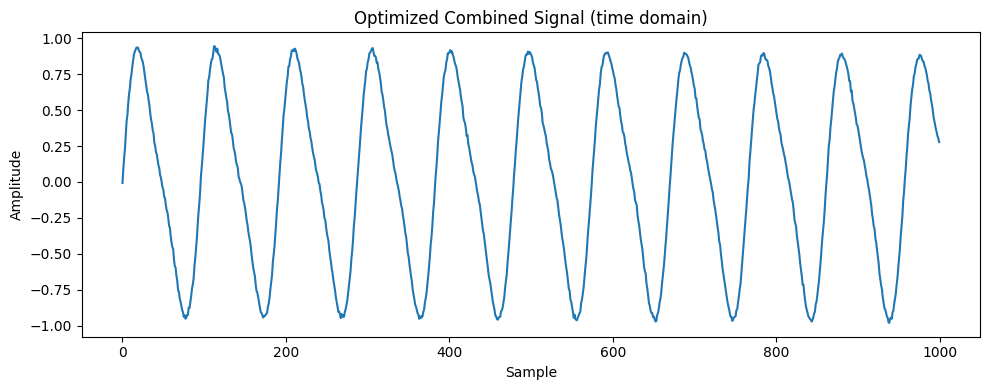

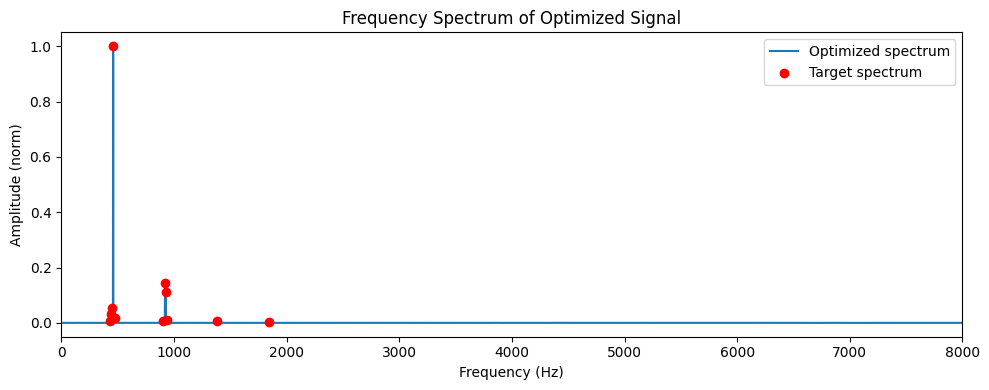

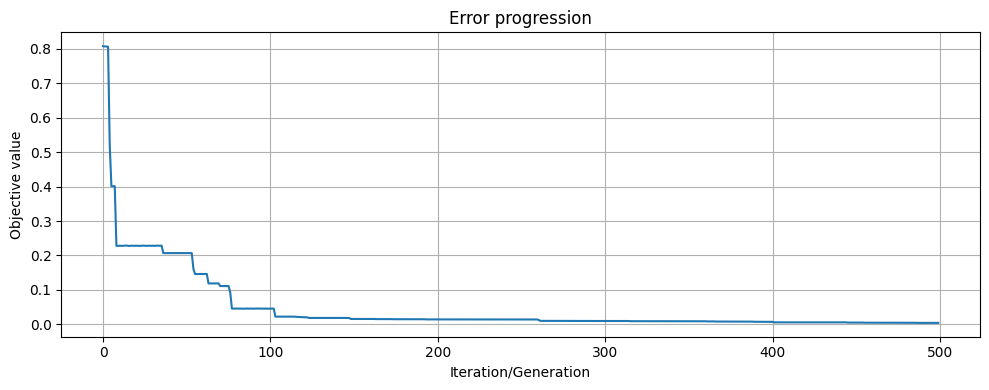

In [10]:
# Build objective + bounds
obj = AdditiveObjective(
    target_freqs=target_freqs,
    target_amps=target_amps,
    metric=METRIC,
    n_partials=N_PARTIALS,
    duration=DURATION, sr=SR, fft_pad=FFT_PAD,
    target_kernel='gaussian', target_bw_hz=2.0,
    waveforms=waveforms if USE_WAVEFORMS else None,
)
bounds = obj.default_bounds(freq_lo=5.0, freq_hi=5000.0, amp_lo=0.0, amp_hi=1.0)

# Run selected optimizer
method = METHOD.lower().strip()
if method == 'de':
    result, history = run_de_optimization(obj, bounds, maxiter=500, popsize=20, workers=-1, tqdm_desc=f'Additive {N_PARTIALS}-osc DE - {METRIC.title()}')
elif method == 'da':
    result, history = run_dual_annealing(obj, bounds, maxiter=500, tqdm_desc=f'Additive {N_PARTIALS}-osc DA - {METRIC.title()}')
elif method == 'bh':
    result, history = run_basinhopping(obj, bounds, maxiter=500, stepsize=0.5, tqdm_desc=f'Additive {N_PARTIALS}-osc BH - {METRIC.title()}')
else:
    raise ValueError(f'Unknown METHOD {METHOD}')

params = np.asarray(result.x, dtype=float)
best = float(result.fun)
print('best objective:', best)
print('params:', params)

# Synthesize final audio
_, y = additive_synth(params, duration=DURATION, sr=SR, waveforms=(waveforms if USE_WAVEFORMS else None))

# Build a shared suffix for filenames
from datetime import datetime
suffix = f'{method}_{METRIC}_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
base_prefix = f'optimized_output_additive_{target_name}'
wav_path = os.path.join('rendered_audio', f'{base_prefix}_{suffix}.wav')
_ = save_wav(wav_path, y, sr=SR, fade_in_ms=FADE_IN_MS, fade_out_ms=FADE_OUT_MS, add_info=False, add_time=False)

# Save TSV of final partials + nice printout
tsv_path = os.path.join('tsv', f'final_values_additive_{target_name}_{suffix}.tsv')
df_final = save_and_display_final_values_additive(params, tsv_path, waveforms=(waveforms if USE_WAVEFORMS else None))
display(df_final)

# Plots (time, spectrum, error)
plot_time(y, SR, n_samples=1000, show=True)
plot_spectrum(y, SR, target_freqs=target_freqs, target_amps=target_amps, xlim=(0, 8000), fft_pad=FFT_PAD, show=True)
plt.figure(figsize=(10,4))
plt.plot(history)
plt.title('Error progression')
plt.xlabel('Iteration/Generation')
plt.ylabel('Objective value')
plt.grid(True)
plt.tight_layout()
plt.show()

display(Audio(filename=wav_path))


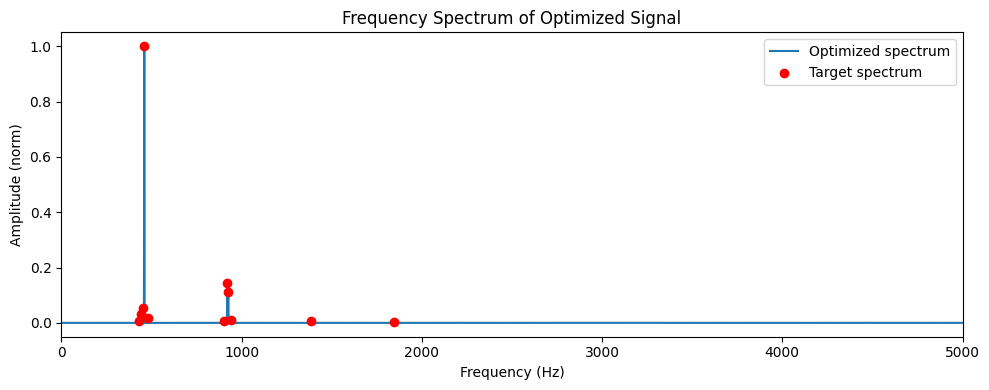

In [11]:
plot_spectrum(y, sr=SR, target_freqs=target_freqs, target_amps=target_amps, xlim=(0, 5000), fft_pad=FFT_PAD, show=False)

In [12]:
# Render 10-second optimized audio
from IPython.display import Audio, display
LONG_DURATION = 10.0
out_path_long = f"rendered_audio/optimized_output_additive_{target_name}_long_{LONG_DURATION:.1f}s.wav"
# Use additive synth with optional waveforms for long render
t_long, y_long = additive_synth(
    params,
    duration=LONG_DURATION,
    sr=SR,
    waveforms=(waveforms if USE_WAVEFORMS else None),
)
out_path_long = save_wav(
    out_path_long,
    y_long,
    sr=SR,
    fade_in_ms=FADE_IN_MS,
    fade_out_ms=FADE_OUT_MS,
    add_info=True,
    add_time=True,
)
display(Audio(filename=out_path_long))
print(f"{LONG_DURATION:.1f}s optimized output saved to {out_path_long}")


[save_wav] wrote: c:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\rendered_audio\optimized_output_additive_voice-single2_long_10.0s_de_cosine_20250910-003447.wav


10.0s optimized output saved to rendered_audio\optimized_output_additive_voice-single2_long_10.0s_de_cosine_20250910-003447.wav
